#Introducción

La clasificación de imágenes y, por tanto, la visión por computadora se ha convertido en un estudio relevante en la sociedad moderna generando nuevas industrias como lo son los carros de conducción autónoma y los robots de asistencia doméstica o industrial, entre otras aplicaciones. En el presente trabajo me propongo explorar distintos modelos de clasificación de imágenes y comparar los resultados que se obtiene en el entrenamiento de un dataset de imágenes de lenguaje de señas. El objetivo es comparar un modelo denso, un modelo con capas convolucionales y modelos preentrenados de clasificación de imágenes. El problema principal consiste en la discusión de si siempre es viable o eficiente utilizar un modelo preentrenado o mejor el uso de un modelo más sencillo para determinados problemas. Si bien es usual la inmediata elección de un modelo preentrenado para abordar cualquier problema, estos modelos son muy robustos y pueden llegar a tener muchos parámetros entrenables que consumirían muchos recursos computacionales y se demorarían muchísimo más tiempo en entrenar. Es importante entender, por tanto, que en determinadas ocasiones puede ser un punto de control en el proyecto zanjar la discusión de si es más viable sacrificar exactitud al usar un modelo más sencillo para optimizar uso de recursos y tiempo.

#Metodología

En primer lugar se procede con la extracción de los datos. Para el desarrollo del proyecto usaré una base de datos que tiene habilitada la plataforma Platzi que consiste en imágenes de lenguajes de señas.

##Extracción de los datos
Mediante el siguiente comando se cargará en un zip el dataset que se usará en el proyecto

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip \
    -O /tmp/sign-language-img.zip

--2025-02-09 22:47:47--  https://storage.googleapis.com/platzi-tf2/sign-language-img.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24265584 (23M) [application/zip]
Saving to: ‘/tmp/sign-language-img.zip’

/tmp/sign-language- 100%[===================>]  23.14M  9.80MB/s    in 2.4s    

2025-02-09 22:47:50 (9.80 MB/s) - ‘/tmp/sign-language-img.zip’ saved [24265584/24265584]



#Extracción del archivo zip
Mediante la librería zipfile se descomprime el contenido en una carpeta local y temporal

In [2]:
import os
import zipfile

local_zip="/tmp/sign-language-img.zip"
zip_ref=zipfile.ZipFile(local_zip,"r")
zip_ref.extractall("/tmp/sign-language-img")
zip_ref.close()

#Importación de librerías

In [3]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.5 MB/s eta 0:00:00


In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import os
from tensorflow.keras.callbacks import Callback
import keras_tuner as kt
from tensorflow import keras

Inicialmente se define una función auxiliar para graficar las imágenes que se usarán para entrenar y validar el modelo.

In [5]:
def plotImages(images_arr):
  fig, axes=plt.subplots(1,5,figsize=(10,10))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

def visualizacion_results(history,epochs):
  epochs=[i for i in range(epochs)]
  fig,ax=plt.subplots(1,2)
  train_acc=history.history["accuracy"]
  train_loss=history.history["loss"]
  val_acc=history.history["val_accuracy"]
  val_loss=history.history["val_loss"]
  fig.set_size_inches(16,9)

  ax[0].plot(epochs,train_acc,"go-",label="Entrenamiento accuracy")
  ax[0].plot(epochs,val_acc,"ro-",label="Validation accuracy")
  ax[0].set_title("Entrenamiento & validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")
  ax[0].set_ylim(0.1,1.1)

  ax[1].plot(epochs,train_loss,"go-",label="Entrenamiento loss")
  ax[1].plot(epochs,val_loss,"ro-",label="Validation loss")
  ax[1].set_title("Entrenamiento & validación Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")
  ax[1].set_ylim(0.1,1.1)

  plt.show()

##Creación de los generadores para la carga de las imágenes
Las imágenes descomprimidas quedan guardadas en las siguientes carpetas

In [6]:
train_dir="/tmp/sign-language-img/Train"
test_dir="/tmp/sign-language-img/Test"

Posteriormente, mediante la creación de generadores, se cargan en las variables del entorno lotes de datos para evitar el sobre consumo de memoría a la hora de entrenamiento y validación, adicional, se normalizan los pixeles de las imágenes para que no estén entre 0 y 255 sino entre 0 y 1. Se asigna un 20% del dataset completo al testing y se crea una sub carpeta de validación.

In [7]:
train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255,validation_split=0.2)


Las siguientes declaraciones definen los generadores que permitirán tener lotes de 128 imágenes tanto para entrenamiento como para testing (el testing partido entre validación y test). Adicionalmente, se redimensionan las imágenes a un tamaño de (28,28).

In [8]:
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(28,28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

validation_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(28,28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(28,28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


Con la siguiente línea se definen las clases que clasificará el modelo, que serán las letras del alfabeto excepto la J y la Z ya que estas letras necesitan movimiento y no se pueden identificar con imágenes estáticas.

In [9]:
classes=[char for char in string.ascii_uppercase if char !="J" if char !="Z"]

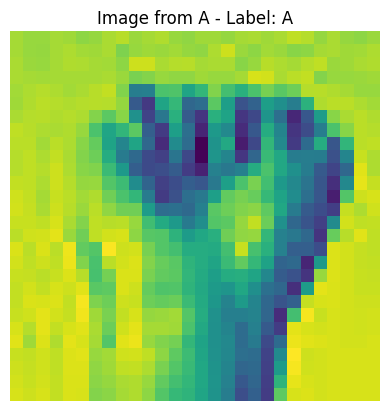

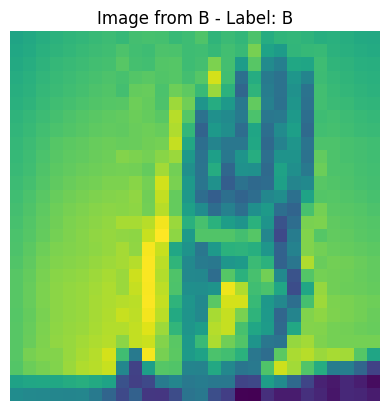

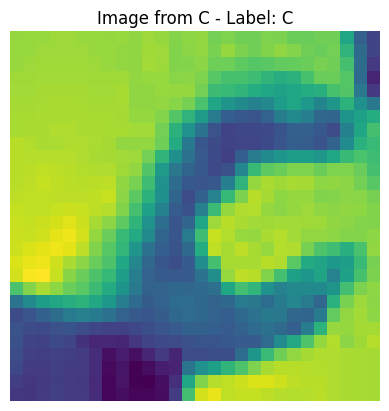

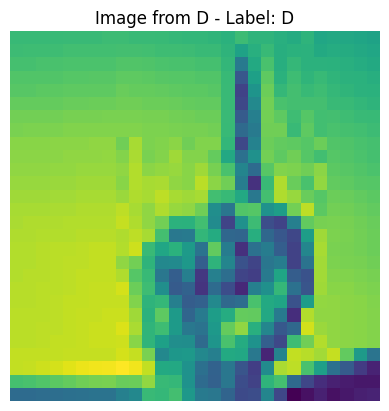

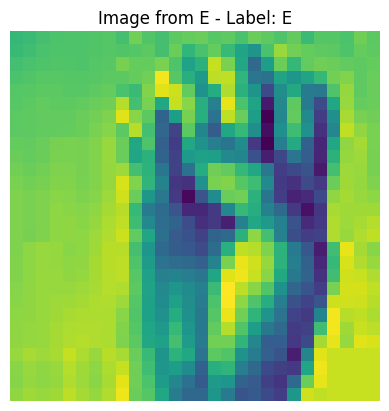

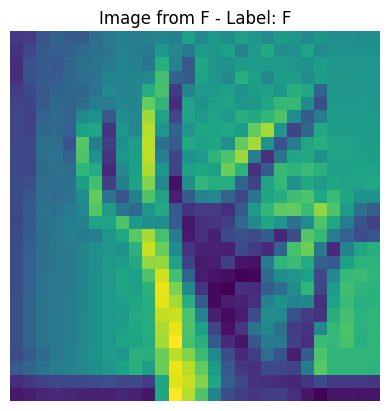

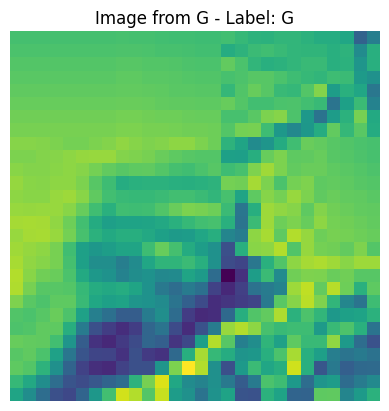

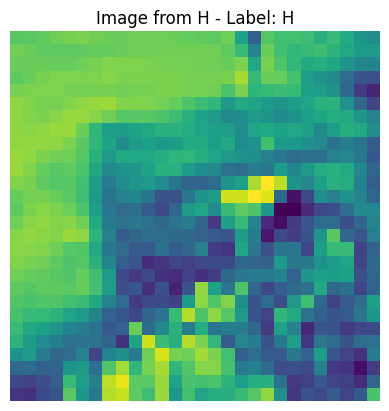

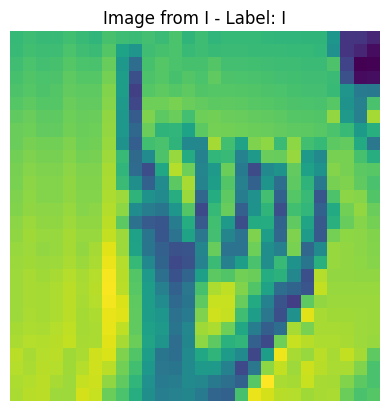

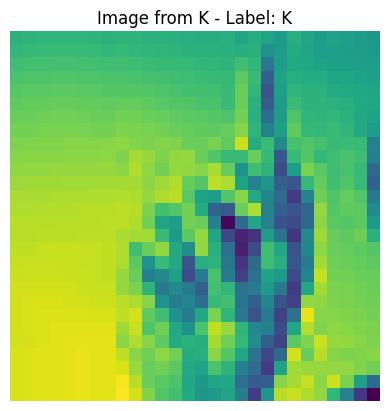

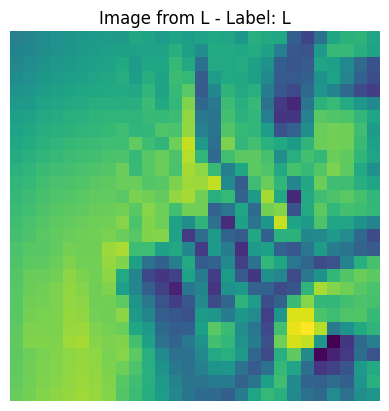

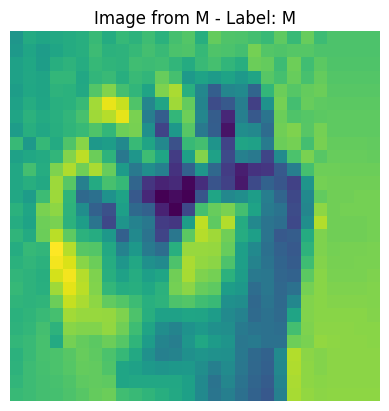

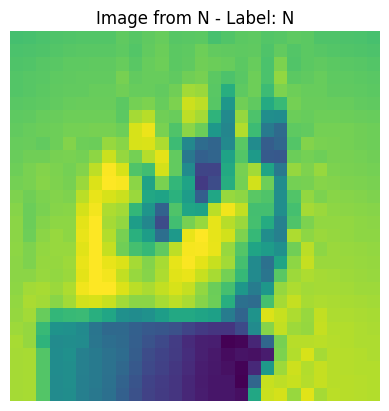

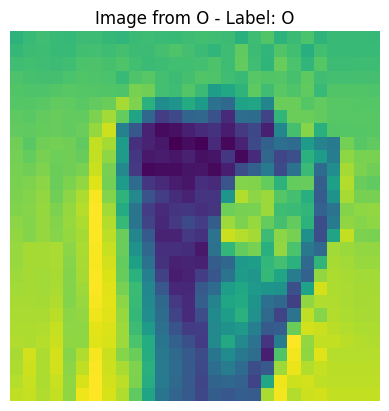

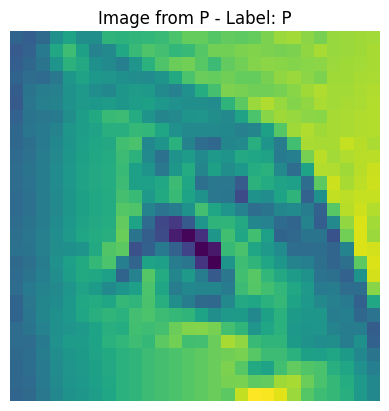

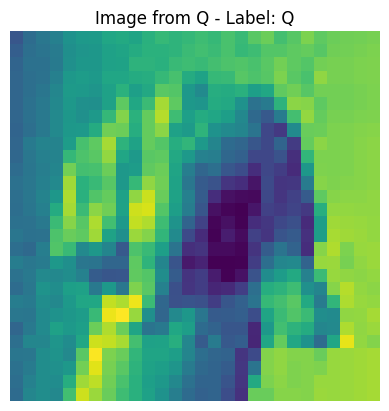

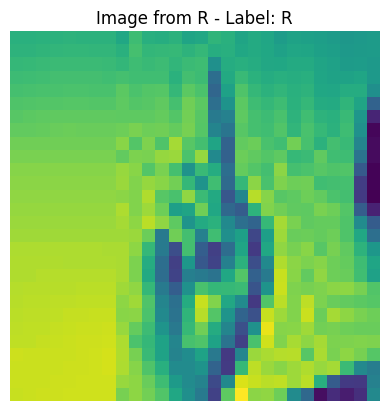

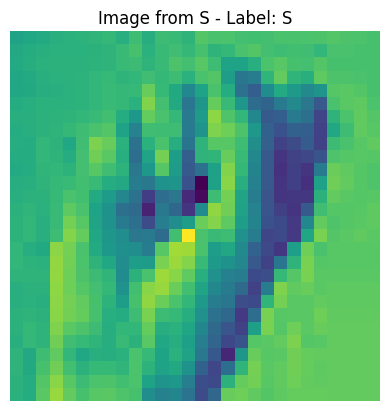

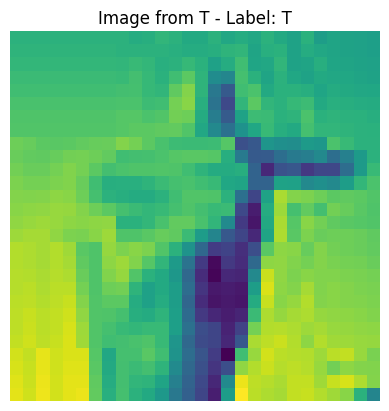

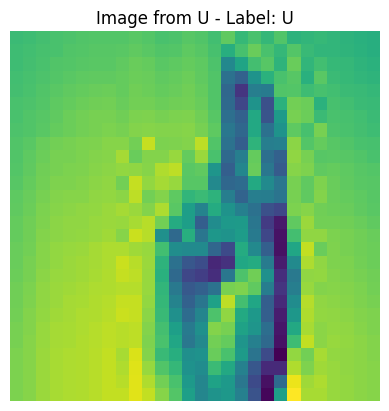

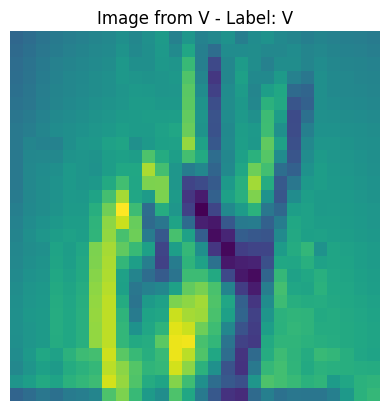

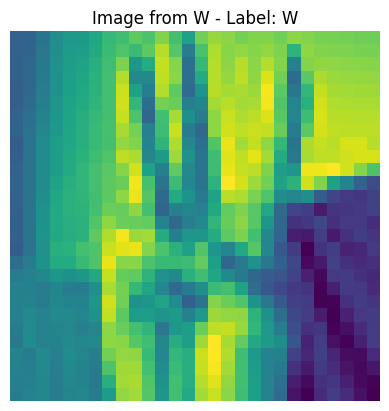

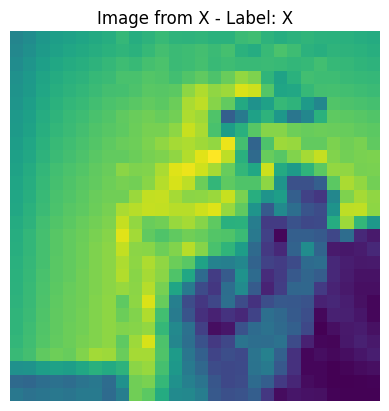

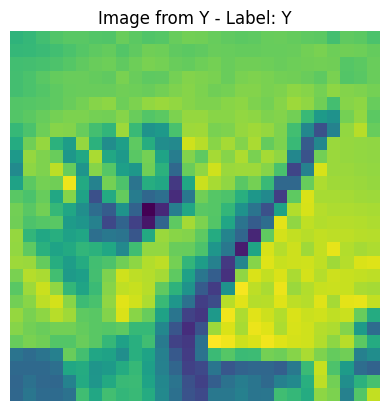

In [10]:
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
      for filename in os.listdir(class_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
          image_path = os.path.join(class_dir, filename)
          try:
            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.title(f"Image from {class_name} - Label: {classes[i]}")
            plt.axis('off')
            plt.show()
            break
          except Exception as e:
            print(f"Error loading or displaying image {filename}: {e}")
          break


##Entrenamiento

###Herramientas

####Early Stopping

Se usará el callback de EarlyStopping donde se hará monitoreo del loss de manera que detenga el entrenamiento cuando esté identificado un overfitting.

In [12]:
callback_early=tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, mode="auto")

###Regularizadores

Para el modelo denso se hará uso del regularizador ridge L2 para evitar el sobre ajuste que se podría presentar en el entrenamiento.

$$
L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{N}(\hat{y}-y)^{2} + \lambda \sum_{i=1}^{N}\theta_{i}^{2}
$$

###Keras Tuner

Para poder hallar los hiper parámetros óptimos de la red densa y convolucional, haré uso del Keras Tuner, el cuál permite realizar múltiples iteraciones del modelo en búsqueda de los parámetros que maximicen la cantidad que se monitorea. En este caso, monitorearé el val_accuracy.

##Modelo Denso

A continuación se crea el modelo denso utilizando la librería keras y consiste en una red neuronal secuencial y completamente interconectada. Se crea una primera capa Input que sería la capa de entrada que recibe la imagen cuya dimensión es de (28,28,1) y consiguiente se introduce una capa Flatten que convertiría la imagen en un vector unidimensional con dimensión 784 (28*28). Las primera capa densa se parametrizará mediante el Keras Tuner y la segunda capa densa tendrá 128 neuronas. Adicional, se tendrán dos capas intermedias de Dropout de manera tal que se descarten pesos para disminuir el overfitting.

In [13]:
def modelo_denso(hp):
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(28,28,1)))
  model.add(tf.keras.layers.Flatten())

  hp_units=hp.Int("units",min_value=32,max_value=512,step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(len(classes),activation="softmax"))

  hp_learning_rate=hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [14]:
tuner_denso=kt.Hyperband(
    modelo_denso,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="models/",
    project_name="tuner"
)

In [15]:
tuner_denso.search(train_generator, epochs=20,validation_data=validation_generator)

Trial 30 Complete [00h 02m 42s]
val_accuracy: 0.7992982268333435

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 31m 38s


In [16]:
best_hps_denso=tuner_denso.get_best_hyperparameters(num_trials=1)[0]

In [17]:
dense=tuner_denso.hypermodel.build(best_hps_denso)

history_dense=dense.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator

)

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1065 - loss: 2.9989 - val_accuracy: 0.4267 - val_loss: 1.9412
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3929 - loss: 1.8605 - val_accuracy: 0.5060 - val_loss: 1.5187
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5471 - loss: 1.3649 - val_accuracy: 0.6119 - val_loss: 1.2103
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6462 - loss: 1.0659 - val_accuracy: 0.6547 - val_loss: 1.0598
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7134 - loss: 0.8650 - val_accuracy: 0.6849 - val_loss: 0.9683
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7522 - loss: 0.7359 - val_accuracy: 0.6723 - val_loss: 0.9914
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7864 - loss: 0.6360 - val_accuracy: 0.6947 - val_loss: 0.9238
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8104 - loss: 0.5568 - val_ac

In [18]:
dense.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 384)                 │         301,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,061,450 (4.05 MB)

 Trainable params: 353,816 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 707,634 (2.70 MB)

In [19]:
dense.evaluate(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7968 - loss: 0.7690


[0.7703920006752014, 0.797964334487915]

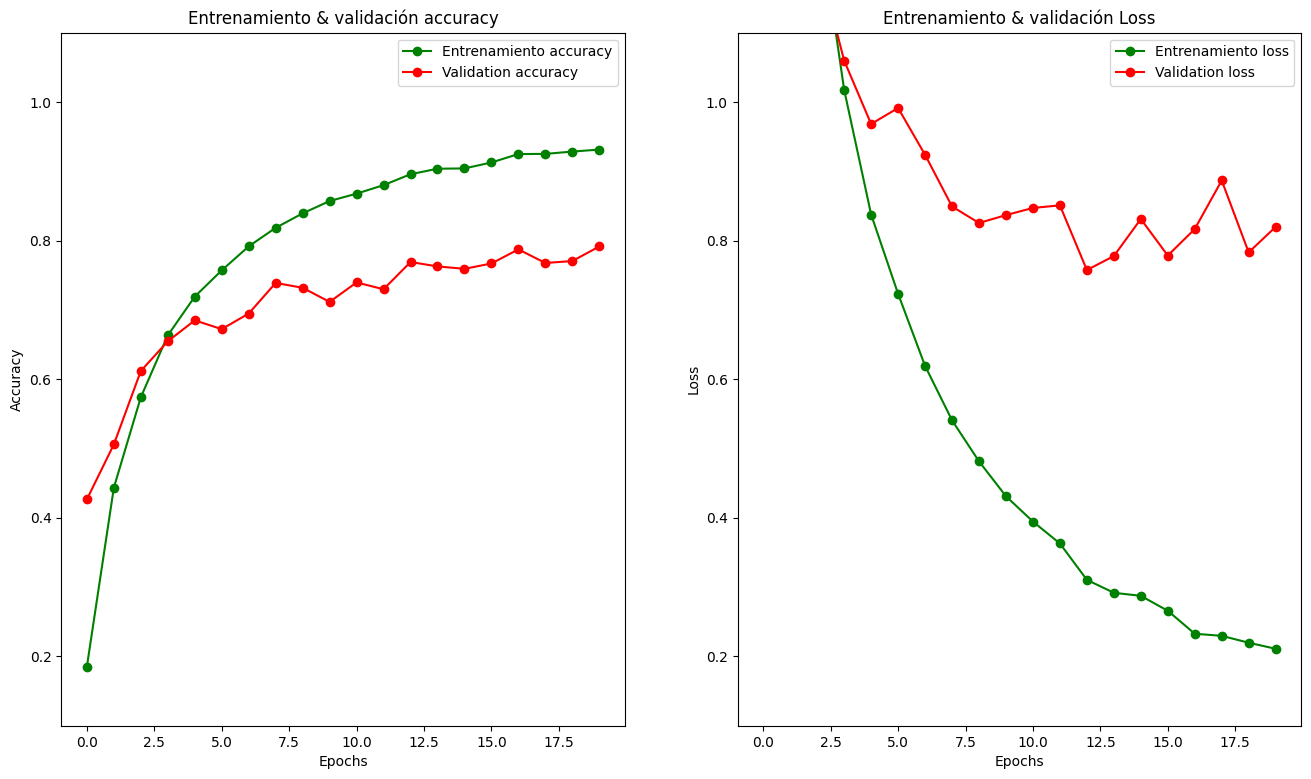

In [20]:
visualizacion_results(history_dense,20)

##Modelo Convolucional

Debido a que son imágenes relativamente sencillas, se utilizará simplemente una capa de convolución que tendrá un número de filtros parametrizado con Keras Tuner y una capa de Pooling. Posteriormente, una red densa para generar la clasificación.

In [21]:
def constructor_convolucional(hp):
  model=tf.keras.models.Sequential()
  hp_units_filt=hp.Int("units_filt",min_value=30,max_value=80,step=10)
  model.add(tf.keras.layers.Conv2D(hp_units_filt,(3,3), activation="relu",input_shape=(28,28,1)))
  model.add(tf.keras.layers.MaxPool2D((2,2)))
  model.add(tf.keras.layers.Flatten())

  hp_units=hp.Int("units",min_value=32,max_value=512,step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(classes),activation="softmax"))

  hp_learning_rate=hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [22]:
tuner_convolucional=kt.Hyperband(
    constructor_convolucional,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="models/",
    project_name="tuner_convolucional"
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
tuner_convolucional.search(train_generator, epochs=20,validation_data=validation_generator)

Trial 30 Complete [00h 02m 45s]
val_accuracy: 0.8540350794792175

Best val_accuracy So Far: 0.8750877380371094
Total elapsed time: 00h 33m 36s


In [24]:
best_hps_convolucional=tuner_convolucional.get_best_hyperparameters(num_trials=1)[0]

In [25]:
best_hps_convolucional.values

{'units_filt': 80,
 'units': 448,
 'learning_rate': 0.001,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0015'}

In [26]:
model_convolucional=tuner_convolucional.hypermodel.build(best_hps_convolucional)

history_convolucional=model_convolucional.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator

)

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.3350 - loss: 2.2721 - val_accuracy: 0.7656 - val_loss: 0.7141
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9200 - loss: 0.3005 - val_accuracy: 0.8365 - val_loss: 0.5741
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9843 - loss: 0.0996 - val_accuracy: 0.8379 - val_loss: 0.6436
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9939 - loss: 0.0608 - val_accuracy: 0.8632 - val_loss: 0.6109
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9956 - loss: 0.0509 - val_accuracy: 0.8807 - val_loss: 0.5738
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9972 - loss: 0.0427 - val_accuracy: 0.8540 - val_loss: 0.6430
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9981 - loss: 0.0380 - val_accuracy: 0.8653 - val_loss: 0.6600
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9979 - loss: 0.0372 - val_a

In [27]:
model_convolucional.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 80)          │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 80)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 13520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 448)                 │       6,057,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,356,330 (70.02 MB)

 Trainable params: 6,118,776 (23.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,237,554 (46.68 MB)

In [28]:
model_convolucional.evaluate(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8777 - loss: 0.6454


[0.6710559725761414, 0.8742331266403198]

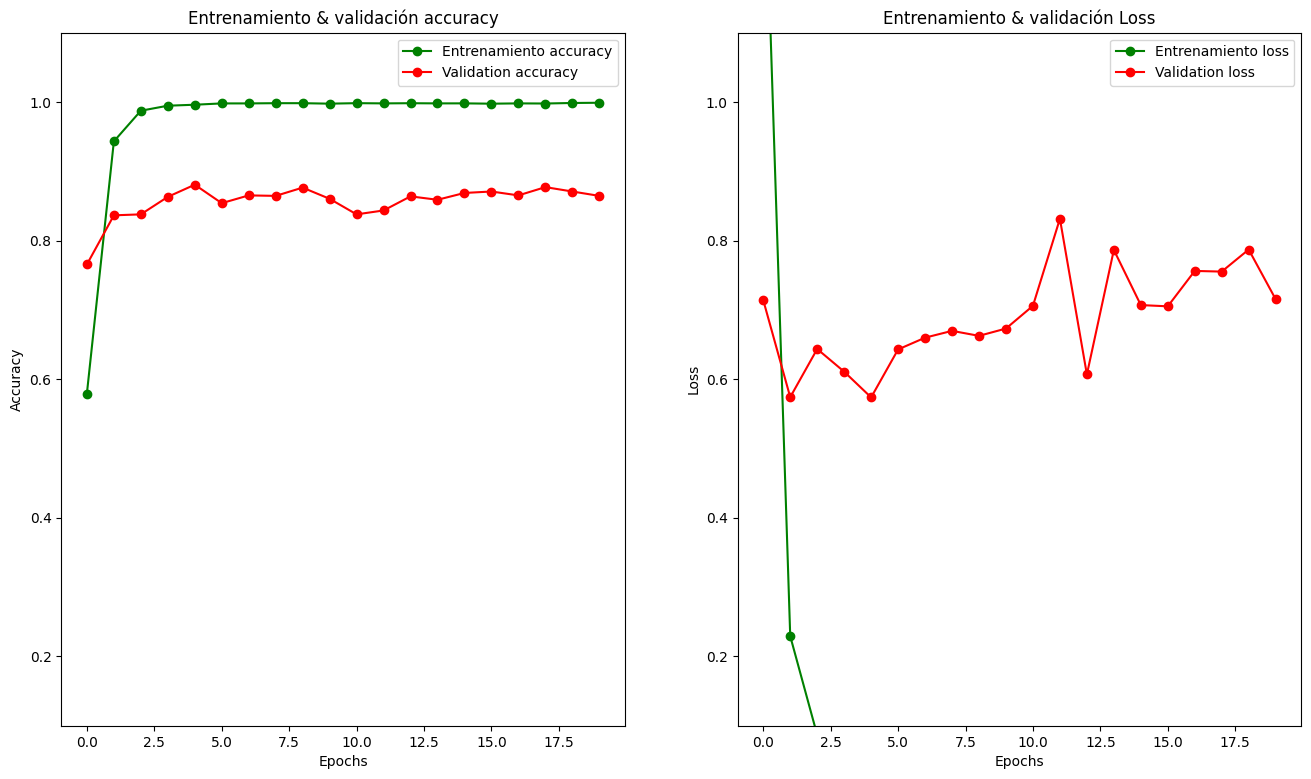

In [29]:
visualizacion_results(history_convolucional,20)

#Modelos pre entrenados

##InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
train_generator_resize=train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=128,
    class_mode="categorical",
    color_mode="rgb",
    subset="training"
)

validation_generator_resize=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=128,
    class_mode="categorical",
    color_mode="rgb",
    subset="validation"
)

test_generator_resize=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=128,
    class_mode="categorical",
    color_mode="rgb",
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


###Última capa mixed 7

In [ ]:
pre_trained_model_inceptionv3_mx7=InceptionV3(
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(150,150,3))
)

for layer in pre_trained_model_inceptionv3_mx7.layers:
  layer.trainable=False

pre_trained_model_inceptionv3_mx7.summary()

last_layer=pre_trained_model_inceptionv3_mx7.get_layer("mixed7")
last_ouput=last_layer.output

x=tf.keras.layers.Flatten()(last_ouput)
x=tf.keras.layers.Dense(128,activation="relu")(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(len(classes), activation="softmax")(x)
model_inceptionv3_mx7=tf.keras.Model(pre_trained_model_inceptionv3_mx7.input,x)

model_inceptionv3_mx7.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_inceptionv3_mx7.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 13,795,384 (52.63 MB)

 Trainable params: 4,820,120 (18.39 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [ ]:
history_model_mx7=model_inceptionv3_mx7.fit(
    train_generator_resize,
    epochs=5,
    validation_data=validation_generator_resize

)

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9784 - loss: 0.0818

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1151s 5s/step - accuracy: 0.9785 - loss: 0.0816 - val_accuracy: 0.9832 - val_loss: 0.0556
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1123s 5s/step - accuracy: 0.9994 - loss: 0.0060 - val_accuracy: 0.9804 - val_loss: 0.0655
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1147s 5s/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9853 - val_loss: 0.0431
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1119s 5s/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9846 - val_loss: 0.0352
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1158s 5s/step - accuracy: 0.9999 - loss: 7.6265e-04 - val_accuracy: 0.9853 - val_loss: 0.0373


In [ ]:
results = model_inceptionv3_mx7.evaluate(test_generator_resize)

57/57 ━━━━━━━━━━━━━━━━━━━━ 276s 5s/step - accuracy: 0.9845 - loss: 0.0397


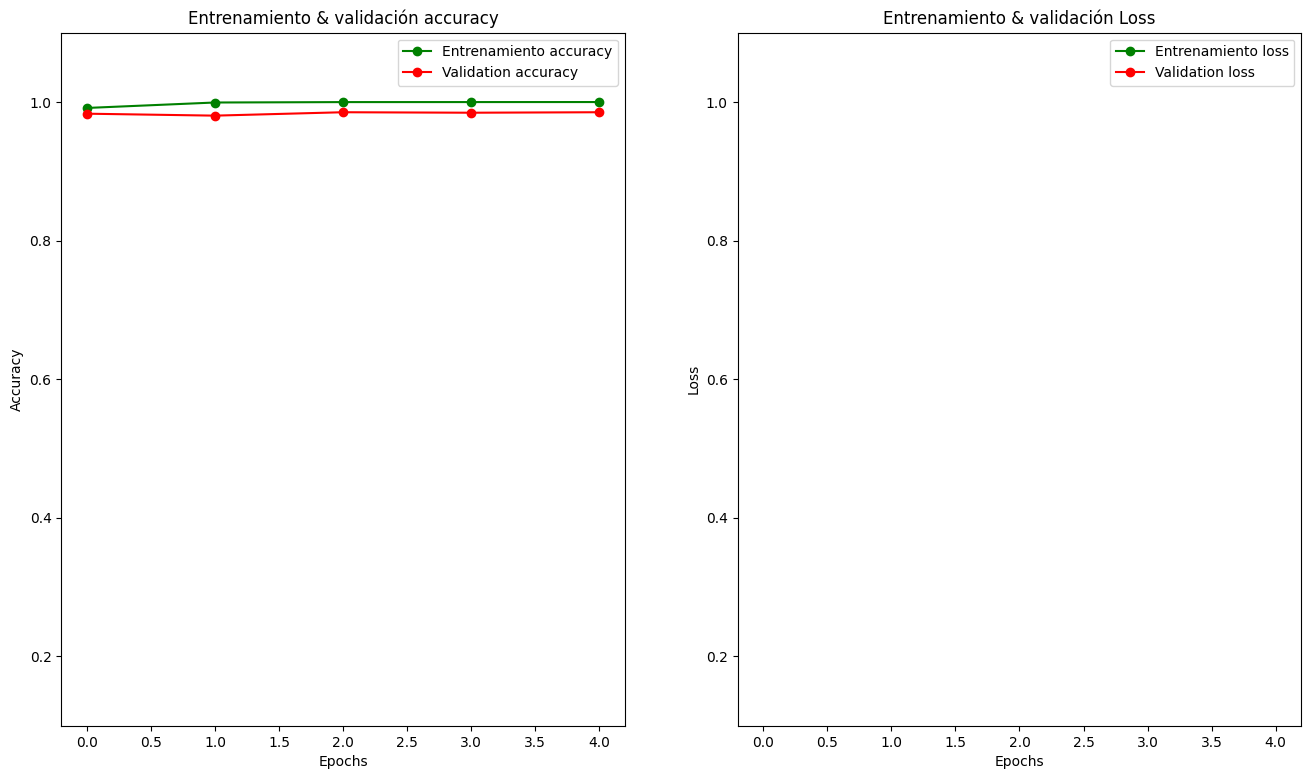

In [ ]:
visualizacion_results(history_model_mx7,5)

##EfficientNetV2

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow import keras

In [ ]:
pre_trained_model_eff=keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=False,
    name="efficientnetv2-b0",
)

for layer in pre_trained_model_eff.layers:
  layer.trainable=False

In [ ]:
pre_trained_model_eff.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 64, 64, 16)     │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 64, 64, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 64, 64, 16)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 32, 32, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 32, 32, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 32, 32, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 32, 32, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 32, 32, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2b_expand_conv       │ (None, 32, 32, 128)    │         36,864 │ block2a_project_bn[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2b_expand_bn    

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
last_layer_eff=pre_trained_model_eff.get_layer("block6b_drop")
last_ouput_eff=last_layer_eff.output

x=tf.keras.layers.Flatten()(last_ouput_eff)
x=tf.keras.layers.Dense(128,activation="relu")(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(len(classes), activation="softmax")(x)
model_eff=tf.keras.Model(pre_trained_model_eff.input,x)

model_eff.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_eff.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 64, 64, 16)     │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 64, 64, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 64, 64, 16)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 32, 32, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 32, 32, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 32, 32, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 32, 32, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 32, 32, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2b_expand_conv       │ (None, 32, 32, 128)    │         36,864 │ block2a_project_bn[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2b_expand_bn    

 Total params: 2,617,800 (9.99 MB)

 Trainable params: 396,440 (1.51 MB)

 Non-trainable params: 2,221,360 (8.47 MB)

In [ ]:
history_keras=model_eff.fit(
    train_generator_resize,
    epochs=5,
    validation_data=validation_generator_resize,
    callbacks=[callback_early]

)

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.6617 - loss: 1.1973 - val_accuracy: 0.9446 - val_loss: 0.1548
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.8610 - loss: 0.4593 - val_accuracy: 0.9818 - val_loss: 0.0470
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8677 - loss: 0.4417 - val_accuracy: 0.9761 - val_loss: 0.0613
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.8710 - loss: 0.4303 - val_accuracy: 0.9867 - val_loss: 0.0506
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8668 - loss: 0.4444 - val_accuracy: 0.9881 - val_loss: 0.0401


In [ ]:
model_eff.evaluate(test_generator_resize)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9882 - loss: 0.0373


[0.03542158380150795, 0.9882878065109253]

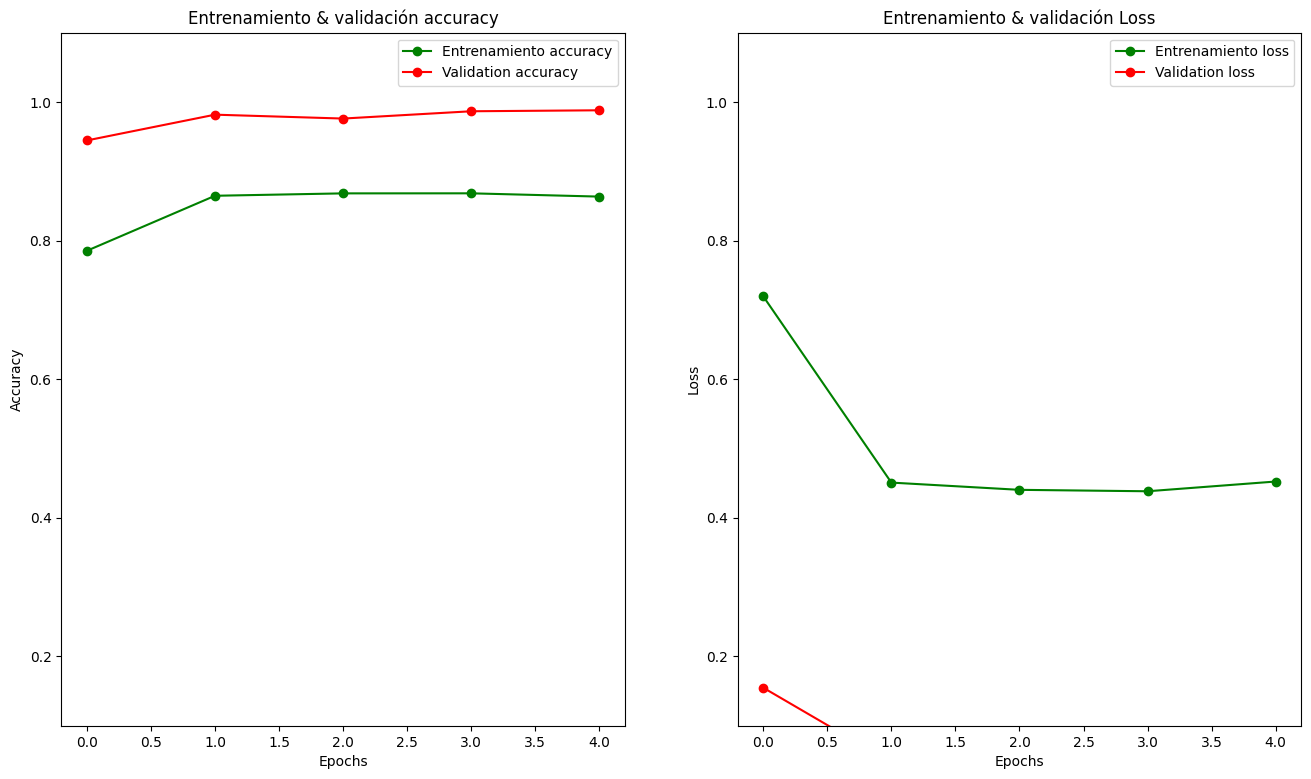

In [ ]:
visualizacion_results(history_keras,5)

#Resultados

Adicional a las gráficas que ya se han mostrado anteriormente con las respectivas gráficas de validation accuracy y loss, se generará una tabla resumen con las evaluaciones:

| Modelo | # Params | Accuracy | Loss |
| --- | --- | --- | --- |
| Denso | 1,412,042 | 0.7979 | 0.77
| Modelo convolucional | 18,356,330 | 0.8742 | 0.67
| InceptionV3 | 13,795,384 | 0.9845 | 0.04
| EfficientNet | 2,617,800 | 0.9882 | 0.04

#Conclusiones



*   Se puede construir desde ceros modelos pequeños que tengan una buena precisión para tareas que son muy específicas.
*   El tiempo de entrenamiento de modelos complejos preentrenados puede ser mucho mayor para tareas específicas con respecto a modelos pequeños.
*   Los modelos preentrenados pueden ser viables si se requiere una alta precisión a cambio de la necesidad de mayores recursos computacionales cuando esté en producción con respecto a modelos pequeños.
*   Si no es requerida necesariamente una alta precisión para tareas específicas puede ser más viable un modelo pequeño haciendo uso de regularizadores en la etapa de entrenamiento para disminuir el overfitting.







